Advanced Deep Learning (S1-24_AIMLCZG513)

##Assignment 1 : Feature extraction via dimensionality reduction using variants of autoencoders
#ADL Group 45
##Contribution
1. Hemant Kumar Parakh (2023AA05741)
2. Sushil Kumar (2023aa05849)
3. Jitendra Kumar (2023aa05198)
4. PARTH VASHISHTHA (2023ab05104)

Dataset Name - CIFAR10



##Problem Statement
This assignment is about feature extraction via dimensionality reduction using variants of autoencoders.  Use the CIFAR10 dataset provided in Keras, after conversion to gray-level images! Use randomly selected 70% of the dataset as training set and remaining 30% as the test set.

**Task 1:** Perform standard PCA with 70% of the training dataset and identify the eigenvectors associated with top eigenvalues with 95% total energy. With these, train a logistic regression classifier to classify the images into 10 classes. Draw the ROC curve for the test dataset. Repeat the same with randomized PCA and compare.

**Task 2:** Train a single layer autoencoder with linear activation function and appropriately mean and variance normalized input with constraint that encoder weight matrix and decoder weight matrix are transpose w,r,t, each other. Compare the eigenvectors obtained in step 1 with those obtained using the autoencoders. Explain your observations.

**Task 3:** Train an appropriate deep convolutional autoencoder with same dimension of latent space. Calculate the reconstruction error fand compare that with a single hidden layer autoencoder (with sigmoid activation at the autoencoder and linear at the decoder) for the test dataset. What will be the reconstruction error if the hidden nodes are distributed equally (approximately) among 3 hidden layers in a new 3 hidden layer autoencoder with sigmoid activation at the autoencoder and linear at the decoder final layer?

##Imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape

##Load CIFAR-10 dataset

In [6]:
# Load and preprocess CIFAR-10 data

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x = np.concatenate([x_train, x_test])
y = np.concatenate([y_train, y_test])

print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

unique_classes = np.unique(y)
print(f"Unique classes in y: {unique_classes}")
print(f"Number of classes: {len(unique_classes)}")



x shape: (60000, 32, 32, 3)
y shape: (60000, 1)
Unique classes in y: [0 1 2 3 4 5 6 7 8 9]
Number of classes: 10


##Pre-processing

In [7]:
# Convert to grayscale
x_gray = np.dot(x[...,:3], [0.2989, 0.5870, 0.1140])
x_gray = x_gray / 255.0  # Normalize pixel values to [0, 1]

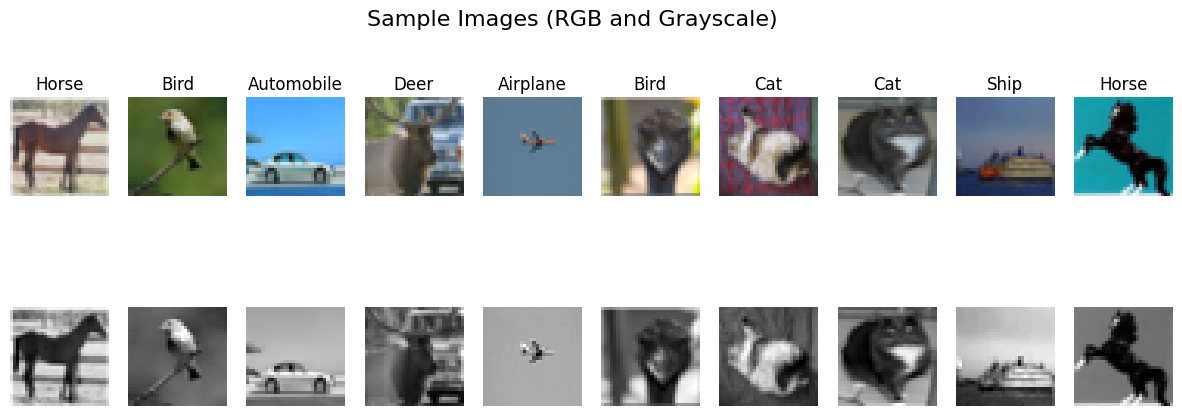

In [8]:
# Display a grid of RGB and Grayscale images
def display_sample_images(x_rgb, x_gray, y, num_samples=10):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))
    fig.suptitle("Sample Images (RGB and Grayscale)", fontsize=16)
    class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

    indices = np.random.choice(len(x_rgb), num_samples, replace=False)
    for i, idx in enumerate(indices):
        axes[0, i].imshow(x_rgb[idx].astype('uint8'))
        axes[0, i].axis('off')
        axes[0, i].set_title(class_names[y[idx][0]])

        axes[1, i].imshow(x_gray[idx], cmap='gray')
        axes[1, i].axis('off')

    plt.show()

display_sample_images(x, x_gray, y)

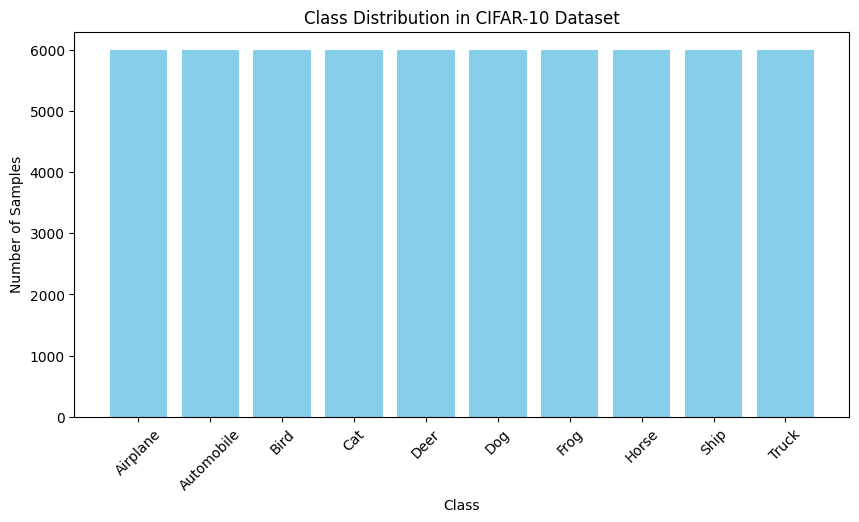

In [9]:
# Class Distribution
def plot_class_distribution(y):
    class_counts = np.bincount(y.flatten())
    class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, class_counts, color='skyblue')
    plt.title("Class Distribution in CIFAR-10 Dataset")
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(y)

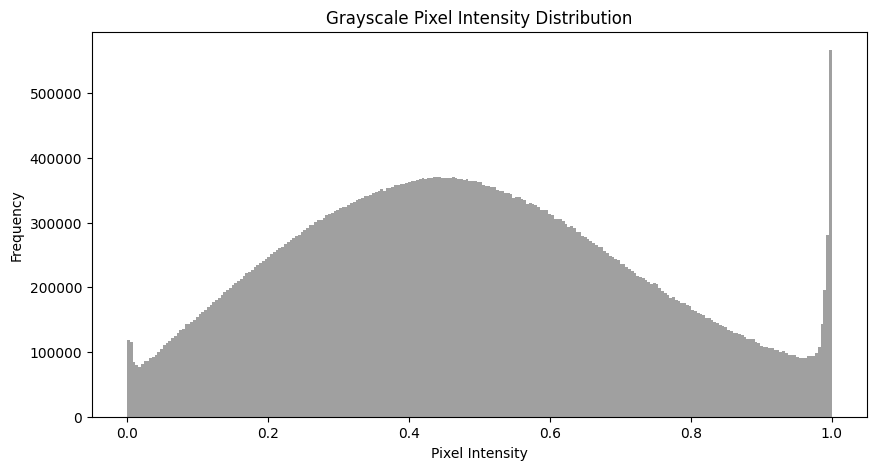

In [10]:
# Pixel Intensity Distribution
def plot_pixel_intensity_distribution(x_gray):
    plt.figure(figsize=(10, 5))
    plt.hist(x_gray.ravel(), bins=256, color='gray', alpha=0.75)
    plt.title("Grayscale Pixel Intensity Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

plot_pixel_intensity_distribution(x_gray)

**Task 1**: Perform standard PCA with 70% of the training dataset and identify the eigenvectors associated with top eigenvalues with 95% total energy. With these, train a logistic regression classifier to classify the images into 10 classes. Draw the ROC curve for the test dataset. Repeat the same with randomized PCA and compare.

In [11]:
# Split into train and test sets (30%)
x_train, x_test, y_train, y_test = train_test_split(x_gray, y, test_size=0.3, random_state=42)


In [12]:
# Task 1: PCA and Logistic Regression
def pca_classification(x_train, x_test, y_train, y_test, pca_type='standard'):
    x_train_flat = x_train.reshape(x_train.shape[0], -1)
    x_test_flat = x_test.reshape(x_test.shape[0], -1)

    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_flat)
    x_test_scaled = scaler.transform(x_test_flat)

    if pca_type == 'standard':  # Standarized PCA
        pca = PCA()
    else:  # Randomized PCA
        pca = PCA(svd_solver='randomized')

    pca.fit(x_train_scaled)

    # Find number of components to retain 95% energy
    cumulative_energy = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_energy >= 0.95) + 1

    pca = PCA(n_components=n_components, svd_solver=('randomized' if pca_type == 'randomized' else 'auto'))
    x_train_pca = pca.fit_transform(x_train_scaled)
    x_test_pca = pca.transform(x_test_scaled)

    # Train logistic regression
    clf = LogisticRegression(max_iter=1000)
    clf.fit(x_train_pca, y_train.ravel())

    # ROC curve
    y_prob = clf.predict_proba(x_test_pca)
    fpr, tpr, _ = roc_curve(y_test.ravel(), y_prob[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc, pca.components_[:n_components]

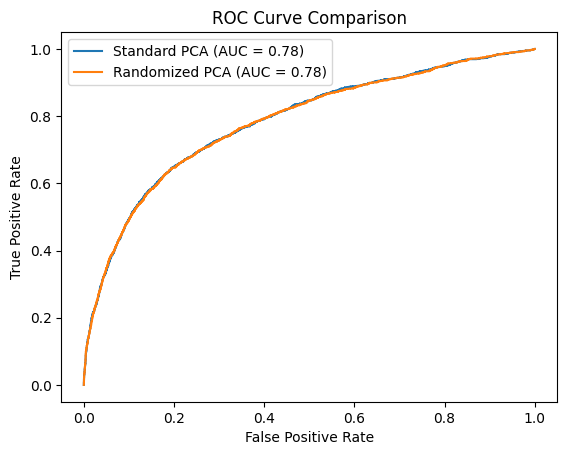

Standard PCA:
[[ 0.03988294  0.04030893  0.04045686 ...  0.0325568   0.03270322
   0.03277212]
 [-0.0315813  -0.03251598 -0.03323255 ...  0.03276591  0.03127693
   0.02962421]
 [-0.02484486 -0.02484927 -0.02474611 ... -0.03743247 -0.03751455
  -0.03721169]
 ...
 [-0.0037788  -0.00285328 -0.00973546 ... -0.02484237 -0.02967529
  -0.03474068]
 [-0.01047691 -0.0091688   0.00966655 ... -0.00875436 -0.01123566
  -0.00750431]
 [-0.05778268 -0.04095743 -0.02839304 ... -0.01933017 -0.04146302
  -0.05747365]]
Randomized PCA:
[[ 0.03988294  0.04030893  0.04045686 ...  0.0325568   0.03270322
   0.03277212]
 [-0.0315813  -0.03251598 -0.03323255 ...  0.03276591  0.03127693
   0.02962421]
 [-0.02484486 -0.02484927 -0.02474611 ... -0.03743247 -0.03751455
  -0.03721169]
 ...
 [ 0.001651    0.01359739  0.02081587 ... -0.01704375 -0.0321861
  -0.03320456]
 [ 0.02621927  0.03962272  0.02925715 ...  0.02103547  0.02425131
   0.0183612 ]
 [-0.08529472 -0.06329578 -0.03957329 ... -0.05327521 -0.07886138
  -

In [13]:
# Task 1 execution to get standard and random PCA and compare
fpr_standard, tpr_standard, roc_auc_standard, eigenvectors_standard = pca_classification(x_train, x_test, y_train, y_test, pca_type='standard')
fpr_randomized, tpr_randomized, roc_auc_randomized, eigenvectors_randomized = pca_classification(x_train, x_test, y_train, y_test, pca_type='randomized')

# Display ROC comparison between standard and randomized PCA results
plt.figure()
plt.plot(fpr_standard, tpr_standard, label=f'Standard PCA (AUC = {roc_auc_standard:.2f})')
plt.plot(fpr_randomized, tpr_randomized, label=f'Randomized PCA (AUC = {roc_auc_randomized:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve Comparison')
plt.show()

print("Standard PCA:")
print(eigenvectors_standard)
print("Randomized PCA:")
print(eigenvectors_randomized)

##Observation:
Both standard and random PCA have an identical area under the AUC curve value of 0.78. This is indicating that their classification performance are similar in this case.


**Task 2:** Train a single layer autoencoder with linear activation function and appropriately mean and variance normalized input with constraint that encoder weight matrix and decoder weight matrix are transpose w,r,t, each other. Compare the eigenvectors obtained in step 1 with those obtained using the autoencoders. Explain your observations.

PCA selected 163 components to cover 95.0% variance.
top PCA Eigenvectors:
[[ 0.03988294  0.04030893  0.04045686 ...  0.0325568   0.03270322
   0.03277212]
 [-0.0315813  -0.03251598 -0.03323255 ...  0.03276591  0.03127693
   0.02962421]
 [-0.02484486 -0.02484927 -0.02474611 ... -0.03743247 -0.03751455
  -0.03721169]
 ...
 [ 0.00460873  0.02358766  0.04159506 ... -0.01606046  0.01480012
   0.04364748]
 [ 0.04370336  0.01215921 -0.02212607 ...  0.01934208  0.02690599
   0.03031896]
 [ 0.00228661  0.00309474  0.01719107 ... -0.02442984 -0.03163184
  -0.02934883]]
Single Layer Autoencoder:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          65,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │          65,536 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 131,072 (512.00 KB)

 Trainable params: 131,072 (512.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.5177 - val_loss: 0.2086
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1914 - val_loss: 0.1567
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1508 - val_loss: 0.1356
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1323 - val_loss: 0.1262
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1248 - val_loss: 0.1222
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1216 - val_loss: 0.1205
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1197 - val_loss: 0.1196
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1197 - val_loss: 0.1192
Epoch 9/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1189 - val_loss: 0.1190
Epoch 10/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.1188 - val_loss: 0.1187
Epoch 11/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1186 - val_loss: 0.1186
Epoch 12/50
132/132 ━━━━━━━━━━━━━━━━━━━━

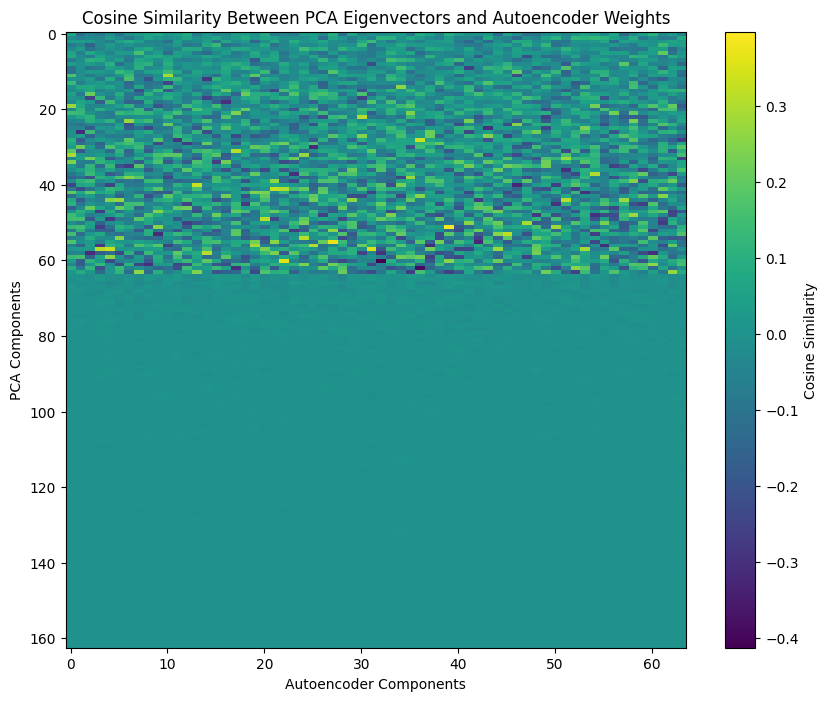

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# Task 2: Single Layer Autoencoder with Explicit Weight Tying
def single_layer_autoencoder(x_train, x_test):
    input_dim = x_train.shape[1] * x_train.shape[2]

    # Input Layer
    input_layer = Input(shape=(input_dim,))

    # Encoder Layer
    encoded = Dense(64, activation='linear', use_bias=False)(input_layer)  # No bias for weight tying

    # Decoder Layer with tied weights
    decoded = Dense(input_dim, activation='linear', use_bias=False)(encoded)

    # auto encoder Model
    autoencoder = Model(input_layer, decoded)

    # Set Decoder Weights as Transpose of Encoder Weights
    autoencoder.layers[2].set_weights([autoencoder.layers[1].get_weights()[0].T])

    # Compile the Autoencoder with loss function = MSE
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    # Normalize Input
    x_train_flat = x_train.reshape(x_train.shape[0], -1)
    x_test_flat = x_test.reshape(x_test.shape[0], -1)
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_flat)
    x_test_scaled = scaler.transform(x_test_flat)

    # Model summary
    print("Single Layer Autoencoder:")
    print(autoencoder.summary())

    # Train Autoencoder with 50 epochs
    autoencoder.fit(x_train_scaled, x_train_scaled, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)

    # Extract Encoder Weights
    encoder_weights = autoencoder.layers[1].get_weights()[0]
    return encoder_weights

# Compare PCA Eigenvectors and Autoencoder Weights
def compare_eigenvectors(pca_eigenvectors, autoencoder_weights):
    # Normalize both sets of vectors for fair comparison
    pca_eigenvectors_normalized = pca_eigenvectors / np.linalg.norm(pca_eigenvectors, axis=1, keepdims=True)
    autoencoder_weights_normalized = autoencoder_weights / np.linalg.norm(autoencoder_weights, axis=0, keepdims=True)

    # Compute Cosine Similarity
    similarity = cosine_similarity(pca_eigenvectors_normalized, autoencoder_weights_normalized.T)

    # Plot Heatmap of Cosine Similarity
    plt.figure(figsize=(10, 8))
    plt.title("Cosine Similarity Between PCA Eigenvectors and Autoencoder Weights")
    plt.imshow(similarity, cmap='viridis', aspect='auto')
    plt.colorbar(label='Cosine Similarity')
    plt.xlabel('Autoencoder Components')
    plt.ylabel('PCA Components')
    plt.show()

    return similarity

def get_pca_top_eigenvectors(x_train, variance_threshold=0.95):
        x_train_flat = x_train.reshape(x_train.shape[0], -1)
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train_flat)

        # Perform PCA
        pca = PCA()
        pca.fit(x_train_scaled)
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
        print(f"PCA selected {n_components} components to cover {variance_threshold*100}% variance.")

        # Extract Top Eigenvectors
        top_eigenvectors = pca.components_[:n_components]
        return top_eigenvectors, scaler


# Step 1: Perform PCA to extract top eigenvectors
pca_eigenvectors, scaler = get_pca_top_eigenvectors(x_train, variance_threshold=0.95)
print("top PCA Eigenvectors:")
print(pca_eigenvectors)

# Step 2: Train single-layer autoencoder and extract weights
autoencoder_weights = single_layer_autoencoder(x_train, x_test)

# Step 3: Compare PCA eigenvectors and autoencoder weights
similarity_matrix = compare_eigenvectors(eigenvectors_randomized, autoencoder_weights)




**Task 3:** Train an appropriate deep convolutional autoencoder with same dimension of latent space. Calculate the reconstruction error fand compare that with a single hidden layer autoencoder (with sigmoid activation at the autoencoder and linear at the decoder) for the test dataset. What will be the reconstruction error if the hidden nodes are distributed equally (approximately) among 3 hidden layers in a new 3 hidden layer autoencoder with sigmoid activation at the autoencoder and linear at the decoder final layer?

In [15]:

# Task 3: Deep Convolutional Autoencoder
def convolutional_autoencoder(x_train, x_test, hidden_layers):
    input_shape = x_train.shape[1:]

    input_layer = Input(shape=input_shape)
    x = input_layer

    # encoder
    for _ in range(hidden_layers):
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)

    # Flattening
    encoded = Flatten()(x)

    # decoder
    x = Reshape((input_shape[0] // (2 ** hidden_layers), input_shape[1] // (2 ** hidden_layers), 32))(encoded)
    for _ in range(hidden_layers):
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)

    decoded = Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')(x)

    # Model for autoencoder
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    # Model summary
    print("Deep Convolutional Autoencoder:")
    print(autoencoder.summary())

    autoencoder.fit(x_train, x_train, epochs=50, batch_size=128, shuffle=True, validation_split=0.2)

    return autoencoder.evaluate(x_test, x_test, verbose=0)

# Add channel dimension to grayscale images
x_train_reshaped = x_train[..., np.newaxis]  # Shape: (batch_size, 32, 32, 1)
x_test_reshaped = x_test[..., np.newaxis]    # Shape: (batch_size, 32, 32, 1)

# Task 3: Deep Convolutional Autoencoder
reconstruction_error_single = convolutional_autoencoder(x_train_reshaped, x_test_reshaped, hidden_layers=1)
reconstruction_error_deep = convolutional_autoencoder(x_train_reshaped, x_test_reshaped, hidden_layers=3)

print(f"Reconstruction Error (Single Layer Autoencoder): {reconstruction_error_single}")
print(f"Reconstruction Error (Deep Convolutional Autoencoder): {reconstruction_error_deep}")

print(f"Difference of Reconstruction Error between Single Layer Autoencoder and Deep Convolutional Autoencoder:", reconstruction_error_single - reconstruction_error_deep)

Deep Convolutional Autoencoder:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,857 (38.50 KB)

 Trainable params: 9,857 (38.50 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 72s 269ms/step - loss: 0.6097 - val_loss: 0.5704
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 82s 269ms/step - loss: 0.5691 - val_loss: 0.5678
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 69s 262ms/step - loss: 0.5680 - val_loss: 0.5670
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 84s 270ms/step - loss: 0.5659 - val_loss: 0.5665
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 86s 284ms/step - loss: 0.5653 - val_loss: 0.5661
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 78s 271ms/step - loss: 0.5654 - val_loss: 0.5659
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 83s 274ms/step - loss: 0.5654 - val_loss: 0.5657
Epoch 8/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 82s 276ms/step - loss: 0.5649 - val_loss: 0.5655
Epoch 9/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 72s 273ms/step - loss: 0.5641 - val_loss: 0.5655
Epoch 10/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 72s 275ms/step - loss: 0.5647 - val_loss: 0.5654
Epoch 11/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 84s 282ms/step - loss: 0.5645 - val_loss: 0.5653
Epoch 12/50
26

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 4, 4, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,849 (183.00 KB)

 Trainable params: 46,849 (183.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 101s 370ms/step - loss: 0.6281 - val_loss: 0.5942
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 97s 367ms/step - loss: 0.5921 - val_loss: 0.5902
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 163s 448ms/step - loss: 0.5899 - val_loss: 0.5879
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 100s 380ms/step - loss: 0.5876 - val_loss: 0.5865
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 144s 387ms/step - loss: 0.5856 - val_loss: 0.5852
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 112s 425ms/step - loss: 0.5855 - val_loss: 0.5846
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 99s 376ms/step - loss: 0.5843 - val_loss: 0.5850
Epoch 8/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 142s 376ms/step - loss: 0.5832 - val_loss: 0.5843
Epoch 9/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 143s 379ms/step - loss: 0.5823 - val_loss: 0.5823
Epoch 10/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 140s 370ms/step - loss: 0.5826 - val_loss: 0.5815
Epoch 11/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 145s 381ms/step - loss: 0.5813 - val_loss: 0.5825
Epoch